# Spectral Fit

In [1]:
from gpxray.chandra.config import ChandraConfig
from gpxray.cli.core import ContextObject
import sherpa.astro.ui as sau
import matplotlib.pyplot as plt
from sherpa_contrib.chart import save_chart_spectrum

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
filename = "../config-broadband.yaml"
config = ChandraConfig.read(filename)

In [3]:
context = ContextObject(config=config, filename=filename)

In [4]:
sau.reset()

In [5]:
sau.show_all()
irf_label = "pks-0637-agn"

In [6]:
DATASET_IDS = [f"obs-id-{index.obs_id}" for index in context.file_indices]

In [7]:
for index in context.file_indices:
    dataset_id = f"obs-id-{index.obs_id}"

    sau.load_data(dataset_id, str(index.paths_spectra_pha[irf_label] / f"{irf_label}.pi"))
    sau.group_counts(dataset_id, 10)

sau.notice(0.5, 7)

read ARF file ../broadband/19692/spectrum/pks-0637-agn/pks-0637-agn.arf
read RMF file ../broadband/19692/spectrum/pks-0637-agn/pks-0637-agn.rmf
read ARF (background) file ../broadband/19692/spectrum/pks-0637-agn/pks-0637-agn_bkg.arf
read RMF (background) file ../broadband/19692/spectrum/pks-0637-agn/pks-0637-agn_bkg.rmf
read background file ../broadband/19692/spectrum/pks-0637-agn/pks-0637-agn_bkg.pi
read ARF file ../broadband/20864/spectrum/pks-0637-agn/pks-0637-agn.arf
read RMF file ../broadband/20864/spectrum/pks-0637-agn/pks-0637-agn.rmf
read ARF (background) file ../broadband/20864/spectrum/pks-0637-agn/pks-0637-agn_bkg.arf
read RMF (background) file ../broadband/20864/spectrum/pks-0637-agn/pks-0637-agn_bkg.rmf
read background file ../broadband/20864/spectrum/pks-0637-agn/pks-0637-agn_bkg.pi
read ARF file ../broadband/20865/spectrum/pks-0637-agn/pks-0637-agn.arf
read RMF file ../broadband/20865/spectrum/pks-0637-agn/pks-0637-agn.rmf
read ARF (background) file ../broadband/20865/sp

In [8]:
sau.set_stat("wstat")
sau.set_method("simplex")

In [9]:
for dataset_id in DATASET_IDS:
    sau.set_source(dataset_id, sau.xsphabs.absorption * sau.powlaw1d.pwl)

sau.xsphabs.absorption.nh.val = 0.09
sau.xsphabs.absorption.nh.frozen = True
sau.powlaw1d.pwl.ampl.val = 0.001
sau.powlaw1d.pwl.gamma.val = 1.5

In [10]:
sau.fit()

Datasets              = 'obs-id-19692', 'obs-id-20864', 'obs-id-20865', 'obs-id-20866', 'obs-id-20867'
Method                = neldermead
Statistic             = wstat
Initial fit statistic = 4743.74
Final fit statistic   = 2754.07 at function evaluation 290
Data points           = 1864
Degrees of freedom    = 1862
Probability [Q-value] = 9.73691e-38
Reduced statistic     = 1.47909
Change in statistic   = 1989.68
   pwl.gamma      1.50442     
   pwl.ampl       0.00119935  


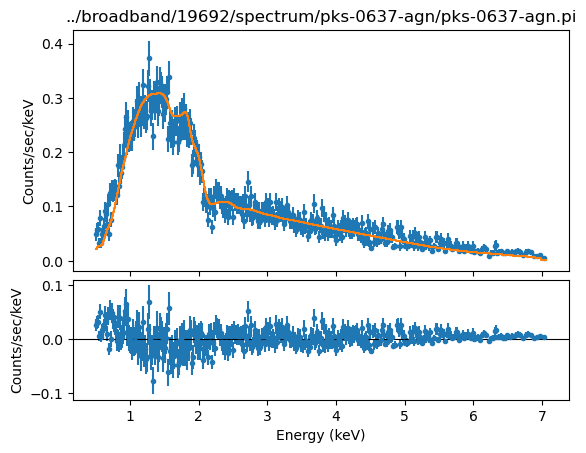

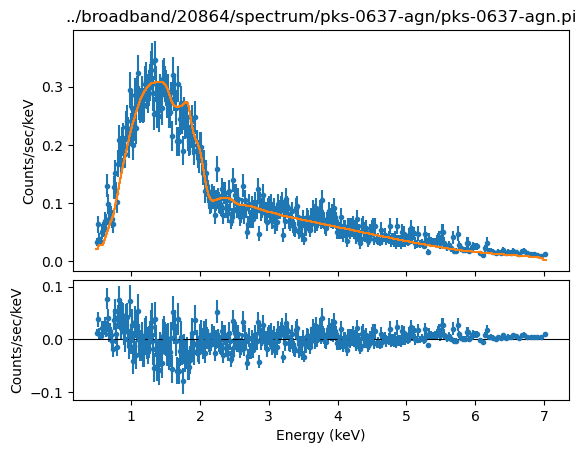

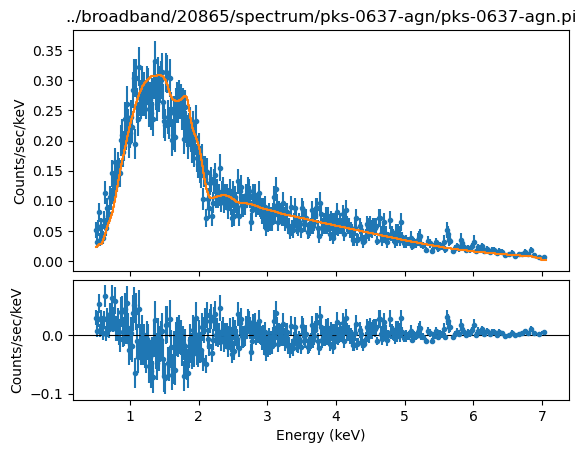

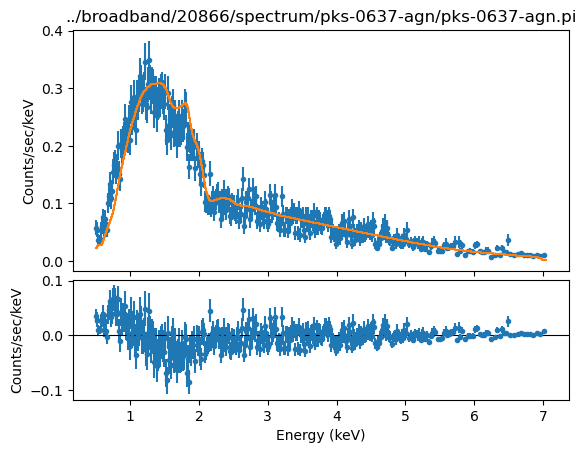

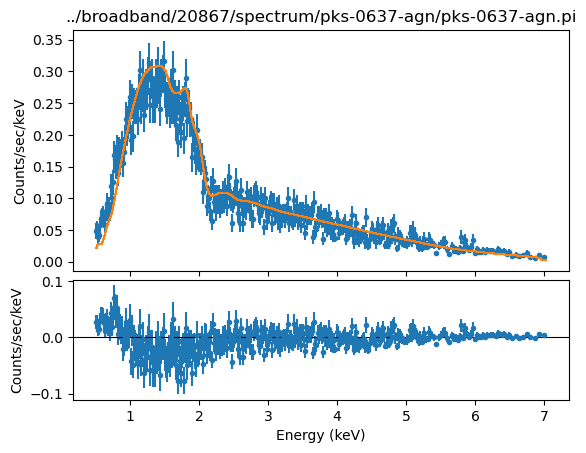

In [11]:
for dataset_id in DATASET_IDS:
    sau.plot_fit_resid(dataset_id)
    plt.show()

In [12]:
for dataset_id in DATASET_IDS:
    sau.set_pileup_model(dataset_id, sau.jdpileup.jdp)

sau.jdpileup.jdp.f.min = 0.85
sau.jdpileup.jdp.ftime = 0.6
sau.jdpileup.jdp.fracexp = 0.987

In [13]:
sau.fit()

Datasets              = 'obs-id-19692', 'obs-id-20864', 'obs-id-20865', 'obs-id-20866', 'obs-id-20867'
Method                = neldermead
Statistic             = wstat
Initial fit statistic = 6482.06
Final fit statistic   = 2038.35 at function evaluation 813
Data points           = 1864
Degrees of freedom    = 1860
Probability [Q-value] = 0.00221007
Reduced statistic     = 1.09589
Change in statistic   = 4443.7
   jdp.alpha      0.999979    
   jdp.f          0.974025    
   pwl.gamma      1.9527      
   pwl.ampl       0.00199716  


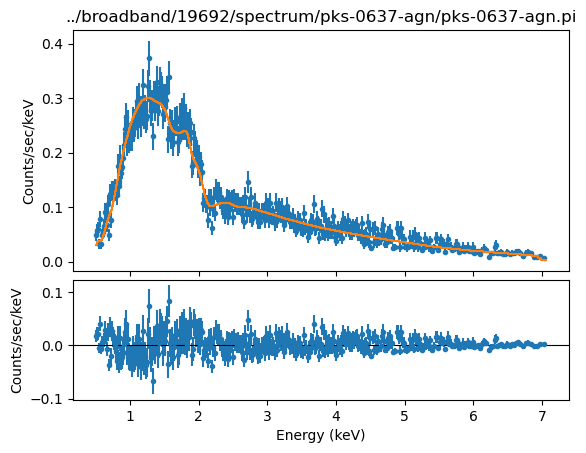

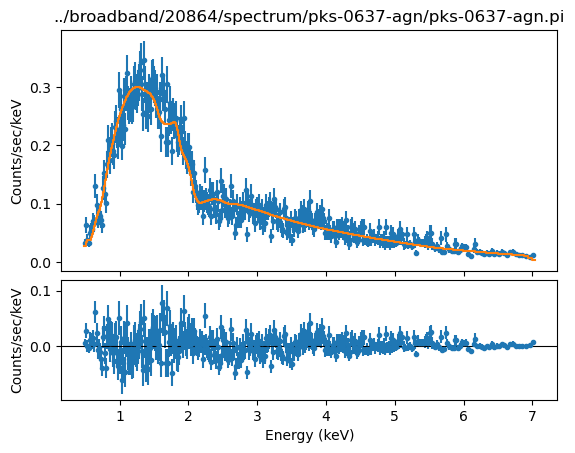

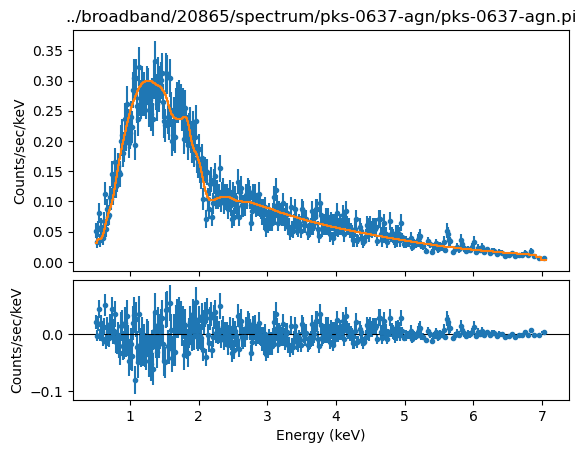

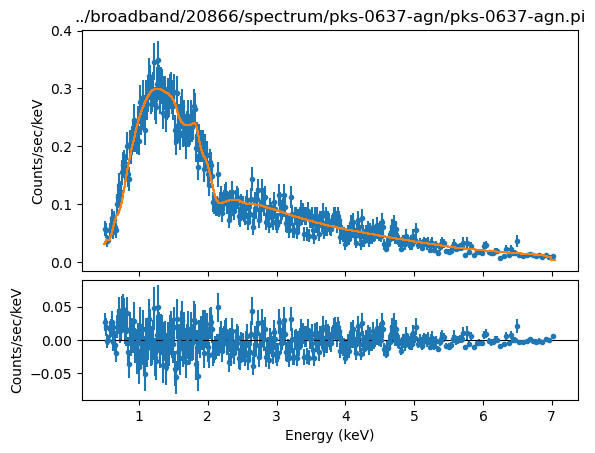

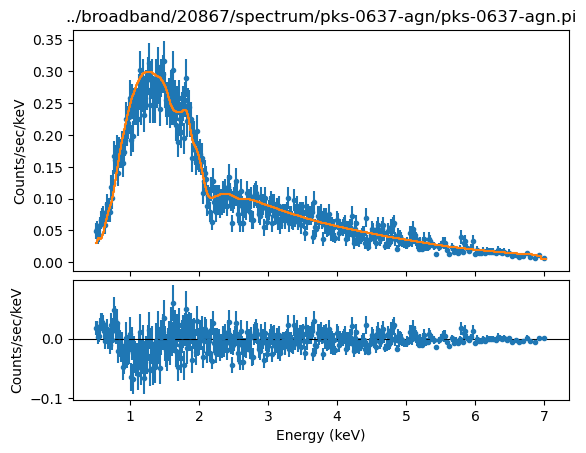

In [14]:
for dataset_id in DATASET_IDS:
    sau.plot_fit_resid(dataset_id)
    plt.show()

In [15]:
for dataset_id in DATASET_IDS:
    sau.set_analysis(dataset_id, "energy", "rate", factor=1)

e_min = 0.5
e_max = 7

for index in context.file_indices:
    filename = index.filenames_spectra[irf_label]
    save_chart_spectrum(
        str(filename), elow=e_min, ehigh=e_max, clobber=True, id=DATASET_IDS[0]
    )

Created: ../broadband/19692/spectrum/pks-0637-agn/source-flux-chart-pks-0637-agn.dat
Created: ../broadband/20864/spectrum/pks-0637-agn/source-flux-chart-pks-0637-agn.dat
Created: ../broadband/20865/spectrum/pks-0637-agn/source-flux-chart-pks-0637-agn.dat
Created: ../broadband/20866/spectrum/pks-0637-agn/source-flux-chart-pks-0637-agn.dat
Created: ../broadband/20867/spectrum/pks-0637-agn/source-flux-chart-pks-0637-agn.dat
